# K-fold cross-validation for model comparison

Different models of diffusion MRI can be compared based on their accuracy in
fitting the diffusion signal. Here, we demonstrate this by comparing two
models: the diffusion tensor model (DTI) and constrained spherical
deconvolution (CSD). These models differ from each other substantially. DTI
approximates the diffusion pattern as a 3D Gaussian distribution, and has only
6 free parameters. CSD, on the other hand, fits many more parameters. The
models aare also not nested, so they cannot be compared using the
log-likelihood ratio.

A general way to perform model comparison is cross-validation [Hastie2008]_. In
this method, a model is fit to some of the data (a *learning set*) and the
model is then used to predict a held-out set (a *testing set*). The model
predictions can then be compared to estimate prediction error on the held out
set. This method has been used for comparison of models such as DTI and CSD
[Rokem2014]_, and has the advantage that it the comparison is imprevious to
differences in the number of parameters in the model, and it can be used to
compare models that are not nested.

In `dipy`, we include an implementation of k-fold cross-validation. In this
method, the data is divided into $k$ different segments. In each iteration
$\frac{1}{k}th$ of the data is held out and the model is fit to the other
$\frac{k-1}{k}$ parts of the data. A prediction of the held out data is done
and recorded. At the end of $k$ iterations a prediction of all of the data will
have been conducted, and this can be compared directly to all of the data.

First, we import that modules needed for this example. In particular, the
:mod:`reconst.cross_validation` module implements k-fold cross-validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 


import dipy.data as dpd
import dipy.reconst.cross_validation as xval
import dipy.reconst.dti as dti
import dipy.reconst.csdeconv as csd
import scipy.stats as stats

We fetch some data and select a couple of voxels to perform comparisons on. One
lies in the corpus callosum (cc), while the other is in the centrum semiovale
(cso), a part of the brain known to contain multiple crossing white matter
fiber populations.

In [2]:
dpd.fetch_stanford_hardi()
img, gtab = dpd.read_stanford_hardi()
data = img.get_data()

cc_vox = data[40, 70, 38]
cso_vox = data[30, 76, 38]

Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 
Dataset is already in place. If you want to fetch it again please first remove the folder /home/ubuntu/.dipy/stanford_hardi 


We initialize each kind of model:

In [3]:
dti_model = dti.TensorModel(gtab)
response, ratio = csd.auto_response(gtab, data, roi_radius=10, fa_thr=0.7)
csd_model = csd.ConstrainedSphericalDeconvModel(gtab, response)

Next, we perform cross-validation for each kind of model, comparing model
predictions to the diffusion MRI data in each one of these voxels.

Note that we use 2-fold cross-validation, which means that in each iteration,
the model will be fit to half of the data, and used to predict the other half.

In [4]:
dti_cc = xval.kfold_xval(dti_model, cc_vox, 2)
csd_cc = xval.kfold_xval(csd_model, cc_vox, 2, response)
dti_cso = xval.kfold_xval(dti_model, cso_vox, 2)
csd_cso = xval.kfold_xval(csd_model, cso_vox, 2, response)

We plot a scatter plot of the data with the model predictions in each of these
voxels, focusing only on the diffusion-weighted measurements (each point
corresponds to a different gradient direction). The two models are compared in
each sub-plot (blue=DTI, red=CSD).

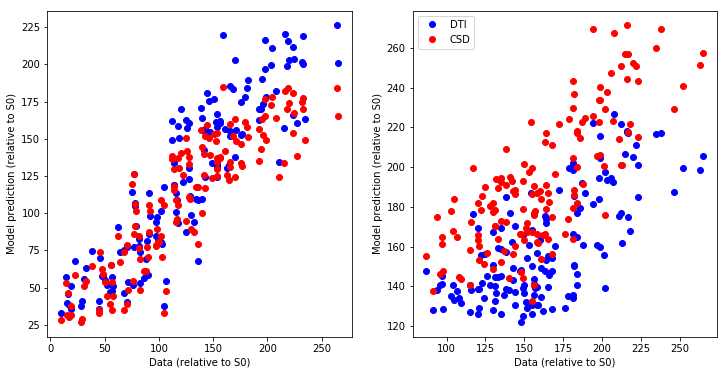

In [5]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches([12,6])
ax[0].plot(cc_vox[~gtab.b0s_mask], dti_cc[~gtab.b0s_mask], 'o', color='b')
ax[0].plot(cc_vox[~gtab.b0s_mask], csd_cc[~gtab.b0s_mask], 'o', color='r')
ax[1].plot(cso_vox[~gtab.b0s_mask], dti_cso[~gtab.b0s_mask], 'o', color='b', label='DTI')
ax[1].plot(cso_vox[~gtab.b0s_mask], csd_cso[~gtab.b0s_mask], 'o', color='r', label='CSD')
plt.legend(loc='upper left')
for this_ax in ax:
    this_ax.set_xlabel('Data (relative to S0)')
    this_ax.set_ylabel('Model prediction (relative to S0)')

We can also quantify the goodness of fit of the models by calculating an
R-squared score:

In [6]:
cc_dti_r2=stats.pearsonr(cc_vox[~gtab.b0s_mask], dti_cc[~gtab.b0s_mask])[0]**2
cc_csd_r2=stats.pearsonr(cc_vox[~gtab.b0s_mask], csd_cc[~gtab.b0s_mask])[0]**2
cso_dti_r2=stats.pearsonr(cso_vox[~gtab.b0s_mask], dti_cso[~gtab.b0s_mask])[0]**2
cso_csd_r2=stats.pearsonr(cso_vox[~gtab.b0s_mask], csd_cso[~gtab.b0s_mask])[0]**2

print("Corpus callosum\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n"
      "\n"
      "Centrum Semiovale\n"
      "DTI R2 : %s\n"
      "CSD R2 : %s\n" % (cc_dti_r2, cc_csd_r2, cso_dti_r2, cso_csd_r2))

Corpus callosum
DTI R2 : 0.7983734494
CSD R2 : 0.789404729624

Centrum Semiovale
DTI R2 : 0.497306858367
CSD R2 : 0.597206157242



As you can see, DTI is a pretty good model for describing the signal in the CC,
while CSD is much better in describing the signal in regions of multiple
crossing fibers.


References
----------

[Hastie, T., Tibshirani, R., Friedman, J. (2008). The Elements of Statistical Learning: Data Mining, Inference and Prediction. Springer-Verlag, Berlin]()

[A. Rokem, J. Yeatman, F. Pestilli, K.N. Kay, A. Mezer, S. van der Walt, B.A. Wandell (2015). Evaluating the accuracy of diffusion MRI models in white matter. PLoS One, DOI: 10.1371/journal.pone.0123272](http://arokem.org/publications/papers/Rokem2015DWImodels.pdf)
